# Trabajo Práctico 2 - Octubre 2025
## Minería de Datos
### Integrantes:
- Irma Carolina Ruíz
- Miranda Pilar Onega
- Rocío Quispe

---

# Librerías

In [1]:
#Análisis exploratorio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparación de los datos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

# Arboles de decisión
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## 1) Companies

### Carga de dataset 1

In [3]:
#!gdown 16mtb2OreBUJxgxR-5rEoENDAdvdserVK

### Análisis Exploratorio de Datos

In [4]:
data_companies = pd.read_csv('1000_Companies.csv')
data_companies.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:
data_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


Las variables del dataset data_companies.csv son casi todas numéricas, salvo "State". A continuación, se visulizarán las distribuciones.

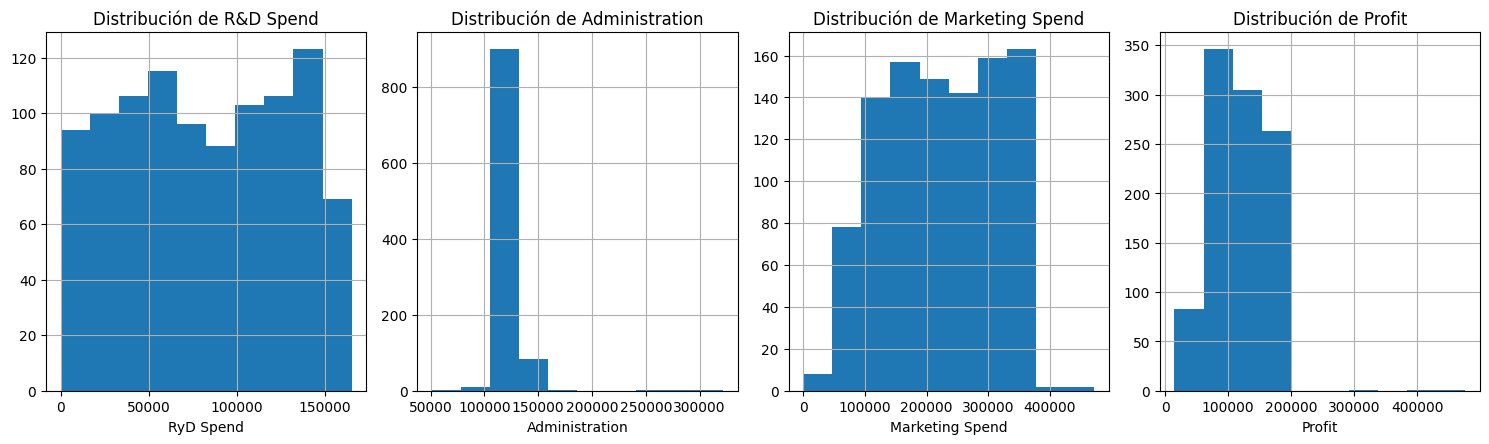

In [6]:
data_companies.hist(figsize=(15, 20), bins=10, layout=(5,4))
plt.tight_layout()

plt.subplot(5, 4, 1)
plt.xlabel("RyD Spend")
plt.title('Distribución de R&D Spend')

plt.subplot(5, 4, 2)
plt.xlabel("Administration")
plt.title('Distribución de Administration')

plt.subplot(5, 4, 3)
plt.xlabel("Marketing Spend")
plt.title('Distribución de Marketing Spend')

plt.subplot(5, 4, 4)
plt.xlabel("Profit")
plt.title('Distribución de Profit')
plt.show()

Las distribuciones encontradas no tienen forma simétrica o normal. **RyD_Spend** tiende al menos  dos picos notorios que rondan los valores 50.000 y 150.000 apróx. Por otro lado, **Administration** se destaca por tener un solo pico muy definido y una cola hacia la derecha, muy extensa. Mientras tanto, **MarketingSpend** tiene forma multimodal, especialmente alrededor de 100.000, 250.000 y400.000. Por último, **Profit** es asimétrica con cola a la izquierda, teniendo muchos datos acumulados entre 0 y 200.000. Se continúa con histogramas para más detalles.

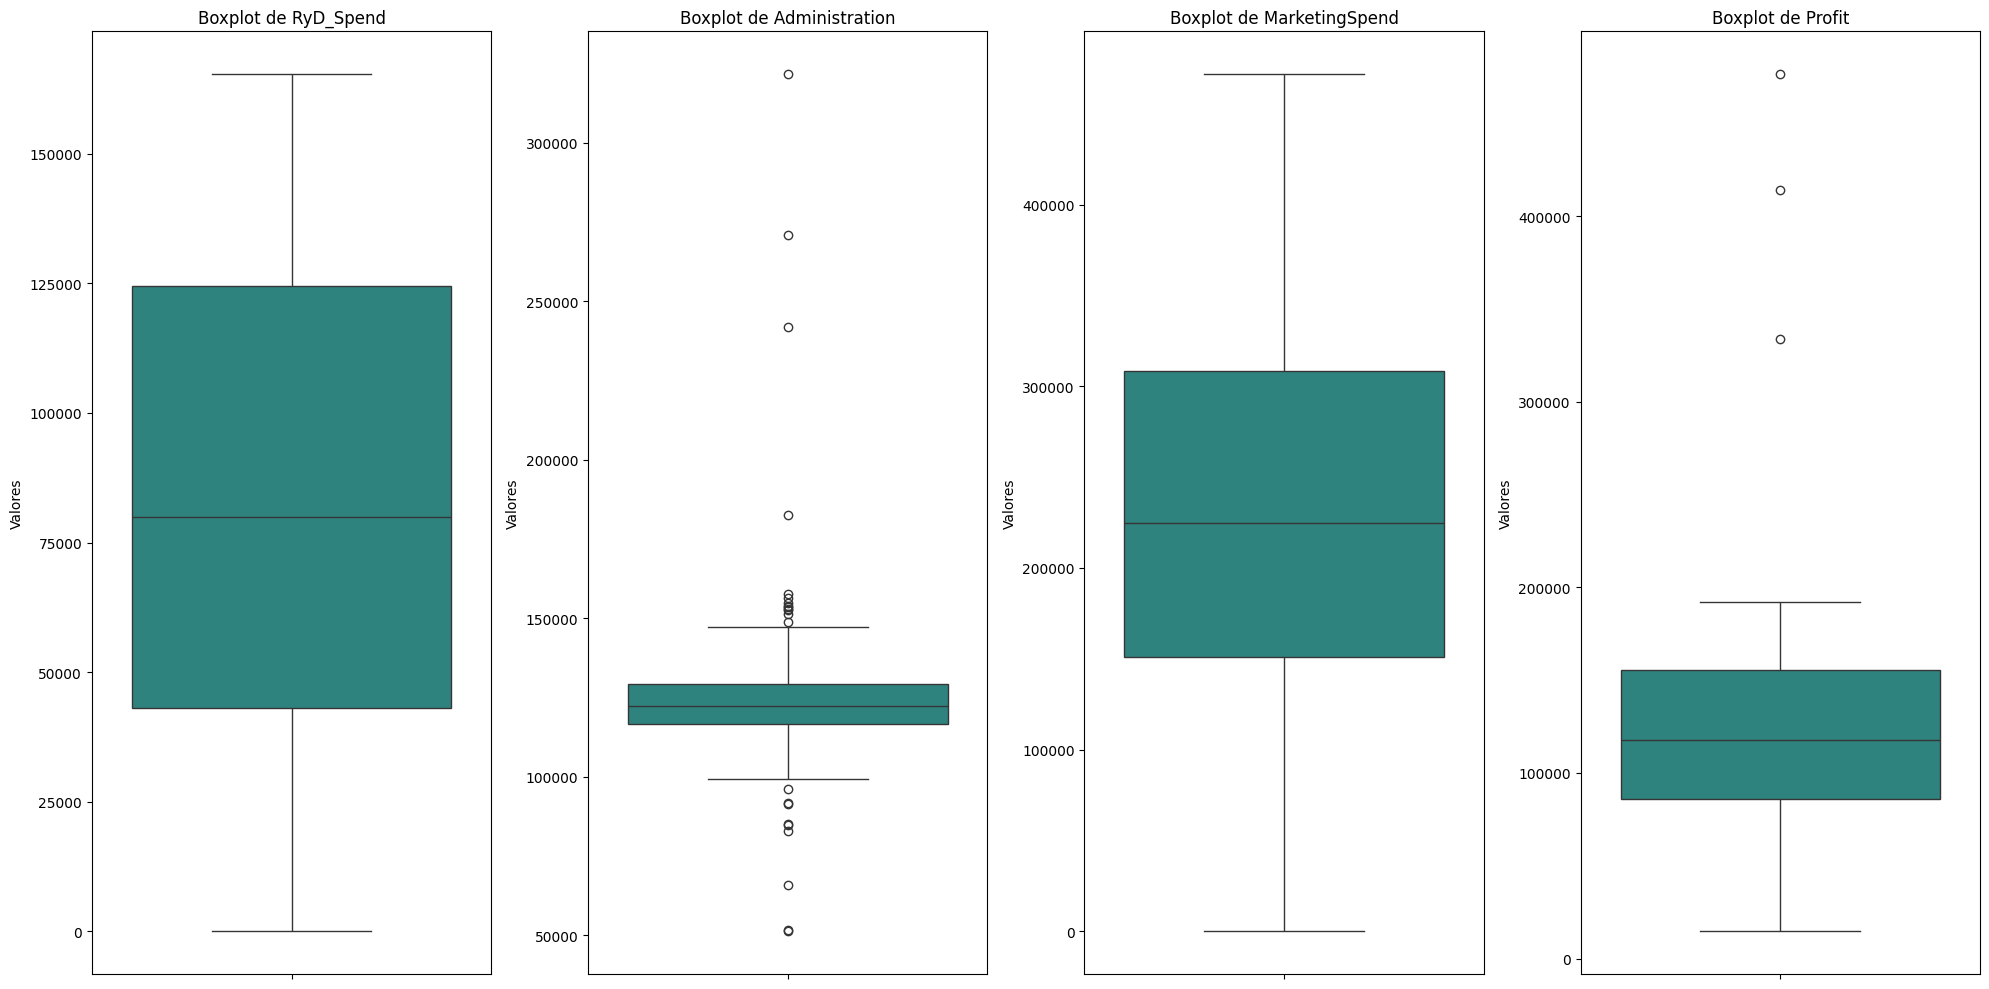

In [7]:
columnas = data_companies.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(columnas):
    sns.boxplot(y=data_companies[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel('Valores')

plt.tight_layout()
plt.show()

Se observan muchos outliers en Administration y Profit, los cuales coinciden con las colas vistas en los histogramas. Siendo que este dataset muestra comportamientos financieros, se consideran que son esperables. Sin embargo, se evaluará si una transformación logarítmica es necesaria antes del escalamiento.

Por otro lado, se visualizan las categorías presentes en **State** que, gracias al resultado de .info(), se sabe que no tiene datos nulos.

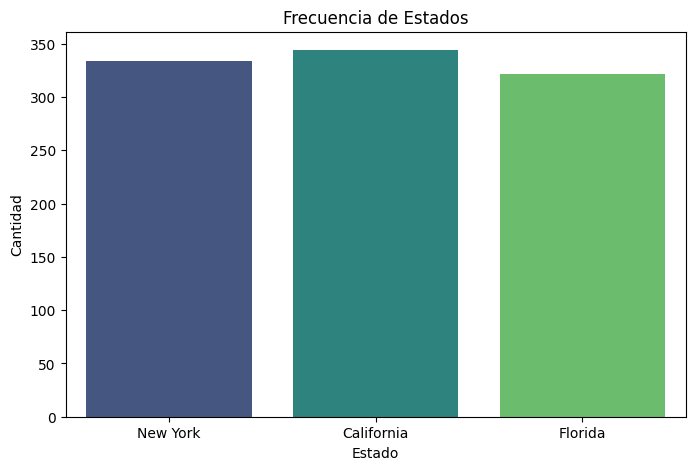

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='State', data=data_companies, palette='viridis')
plt.title('Frecuencia de Estados')
plt.xlabel('Estado')
plt.ylabel('Cantidad')

plt.show()

Se confirma que esta variable tiene solo tres estados de EE.UU. Se procede a hacerlas numéricas con OneHotEncoding.

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
ohe = OneHotEncoder(sparse_output=False)
categ_encod = ohe.fit_transform(data_companies[['State']])

In [11]:
ohe_nombres = ohe.get_feature_names_out()
data_ohe = pd.DataFrame(categ_encod, columns=ohe_nombres, index=data_companies.index)
data_ohe = data_ohe.astype(int)

In [12]:
data_completo = pd.concat([data_companies, data_ohe], axis=1)
data_final = data_completo.drop('State', axis=1)

Ya teniendo los datos en formato numérico, se observan las correlaciones entre las variables no resultantes por OHE.

In [13]:
var_num = data_final[['Profit','RyD_Spend', 'Administration', 'MarketingSpend']]
corr_matrix = var_num.corr()

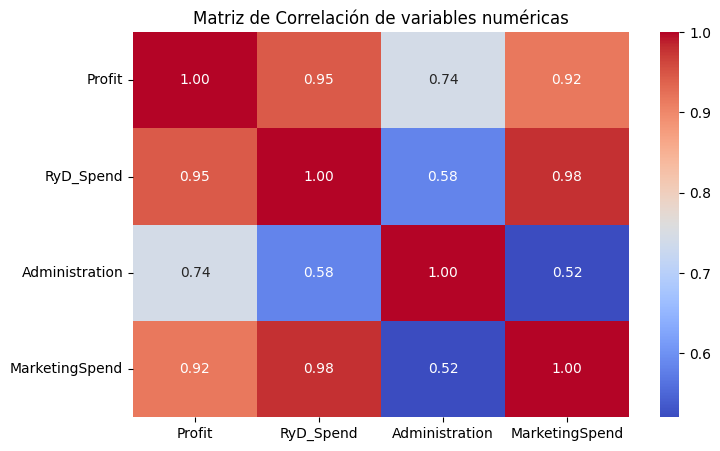

In [14]:
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de variables numéricas')
plt.show()

**Observaciones:**

Teniendo en cuenta que "Profit" será nuestra variable objetivo, se observa que todas las variables predictoras tienen mucha correlación con esta, entre 0.74 y 0.95. Sin embargo, se observa una alta correlación (0.98) entre "RyD_Spend" y "MarketingSpend" es lo que genera multicolinealidad.

In [15]:
data_final = data_final.drop('MarketingSpend', axis=1)

## 2) Árbol de decisión sobre el Comportamiento Financiero

In [16]:
X = data_final.drop('Profit', axis=1)
y = data_final['Profit']

In [17]:
# Primera división:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Datos de entrenamiento: {X_train_80.shape[0]} muestras. Datos de prueba: {X_test_20.shape[0]} muestras.")

Datos de entrenamiento: 800 muestras. Datos de prueba: 200 muestras.


In [18]:
# Segunda división:
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Datos de entrenamiento: {X_train_70.shape[0]} muestras. Datos de prueba: {X_test_30.shape[0]} muestras.")

Datos de entrenamiento: 700 muestras. Datos de prueba: 300 muestras.


Teniendo en cuenta lo visto en el EDA, se continúa con la transformación de la columna Administration y Profit (la cual ya es la variable objetivo).

In [19]:
for conj in [X_train_80, X_test_20, X_train_70, X_test_30]:
    conj['Administration_log'] = np.log1p(conj['Administration'])
    conj.drop('Administration', axis=1, inplace=True)

y_train_80 = np.log1p(y_train_80)
y_train_70 = np.log1p(y_train_70)

#Se guardan las formas originales por seguridad
y_test_20_original = y_test_20.copy()
y_test_30_original = y_test_30.copy()

y_test_20 = np.log1p(y_test_20)
y_test_30 = np.log1p(y_test_30)

In [20]:
var_escalar = ['RyD_Spend', 'Administration_log']

scaler_80 = StandardScaler()

scaler_80.fit(X_train_80[var_escalar])
X_train_80.loc[:, var_escalar] = scaler_80.transform(X_train_80[var_escalar])
X_test_20.loc[:, var_escalar] = scaler_80.transform(X_test_20[var_escalar])

In [21]:
scaler_70 = StandardScaler()

scaler_70.fit(X_train_70[var_escalar])
X_train_70.loc[:, var_escalar] = scaler_70.transform(X_train_70[var_escalar])
X_test_30.loc[:, var_escalar] = scaler_70.transform(X_test_30[var_escalar])

**Modelado y análisis de parámetros**

**Árbol de Decisión 1:**

In [22]:
add = DecisionTreeRegressor(random_state=42)

param = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]}

In [23]:
grid_search_1 = GridSearchCV(estimator=add,
                           param_grid=param,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)
# Entrenamiento Split 1
grid_search_1.fit(X_train_80, y_train_80)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
print("Mejores parámetros encontrados - Árbol 1:")
print(grid_search_1.best_params_)

mejor_arbol_1 = grid_search_1.best_estimator_

Mejores parámetros encontrados - Árbol 1:
{'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10}


Se guardó la versión del árbol con los mejores parámetros. Se grafican los primeros niveles del árbol.

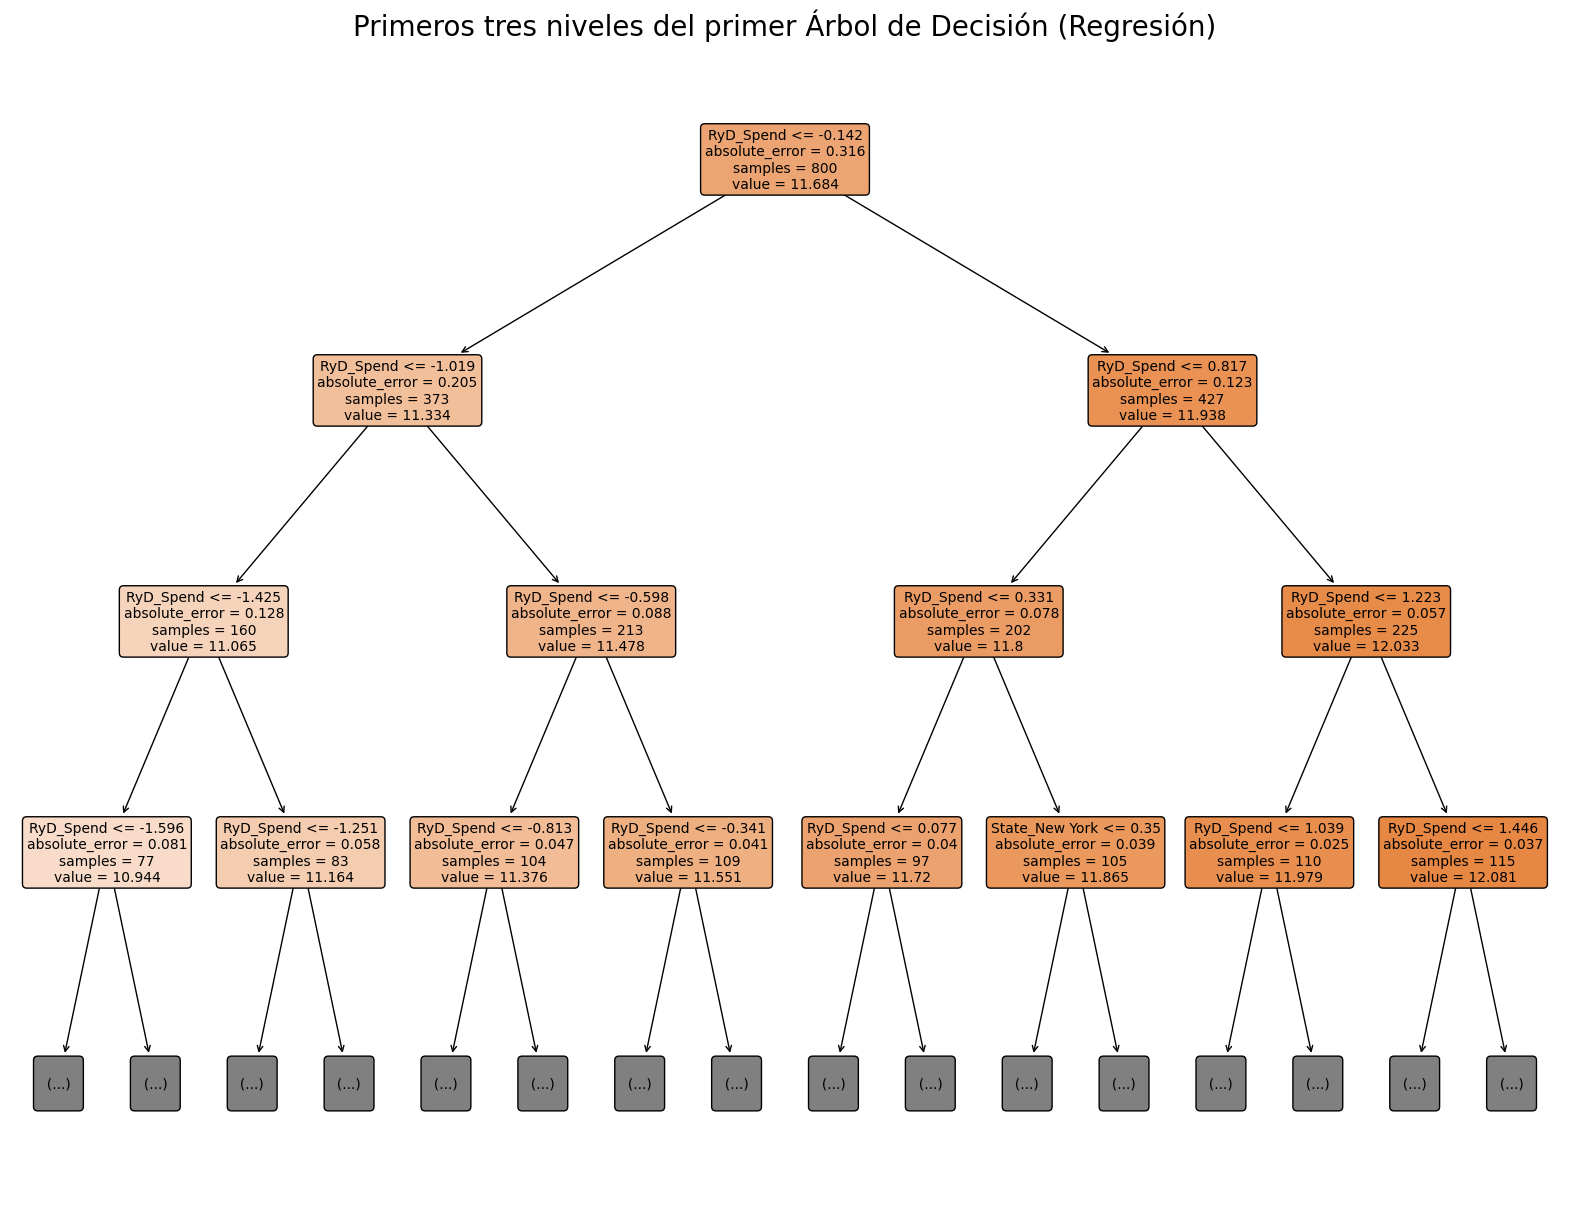

In [25]:
plt.figure(figsize=(20, 15))
plot_tree(mejor_arbol_1,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)

plt.title("Primeros tres niveles del primer Árbol de Decisión (Regresión)", fontsize=20)
plt.show()

**Observaciones:**

En este caso se  muestra que el predictor más importante para Profit es RyD_Spend, el cual domina todas las divisiones de alto nivel. Esto confirma la fuerte correlación de 0.95 observada previamente entre ambas variables. El modelo utiliza el criterio absolute_error en cada nodo para encontrar el umbral óptimo que minimice el error de predicción. 

Las ramas de la derecha valores altos de RyD_Spend suelen tener valores de Profit más altos y un error absoluto menor, indicando que las empresas con mayor RyD Spend son un grupo más homogéneo en términos de ganancias. La importancia casi exclusiva de RyD_Spend en las primeras decisiones del árbol se debe a su alto poder predictivo. La variable Administration solo aparece en niveles inferiores, y otras variables como la geográfica, como State_New York, tienen un impacto muy marginal. Los valores de predicción (value) en los nodos se encuentran en la escala logarítmica (ej., 11.684), lo que indica el valor promedio de Profit para todas las observaciones que caen en ese nodo específico, y el error de cada nodo (absolute_error) representa la dispersión del valor transformado.

**Árbol de Decisión 2:**

In [26]:
add2 = DecisionTreeRegressor(random_state=42)

param_2 = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]}

In [27]:
grid_search_2 = GridSearchCV(estimator=add2,
                           param_grid=param_2,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)
# Entrenamiento Split 2
grid_search_2.fit(X_train_70, y_train_70)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print("Mejores parámetros encontrados - Árbol 2:")
print(grid_search_2.best_params_)

mejor_arbol_2 = grid_search_2.best_estimator_

Mejores parámetros encontrados - Árbol 2:
{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


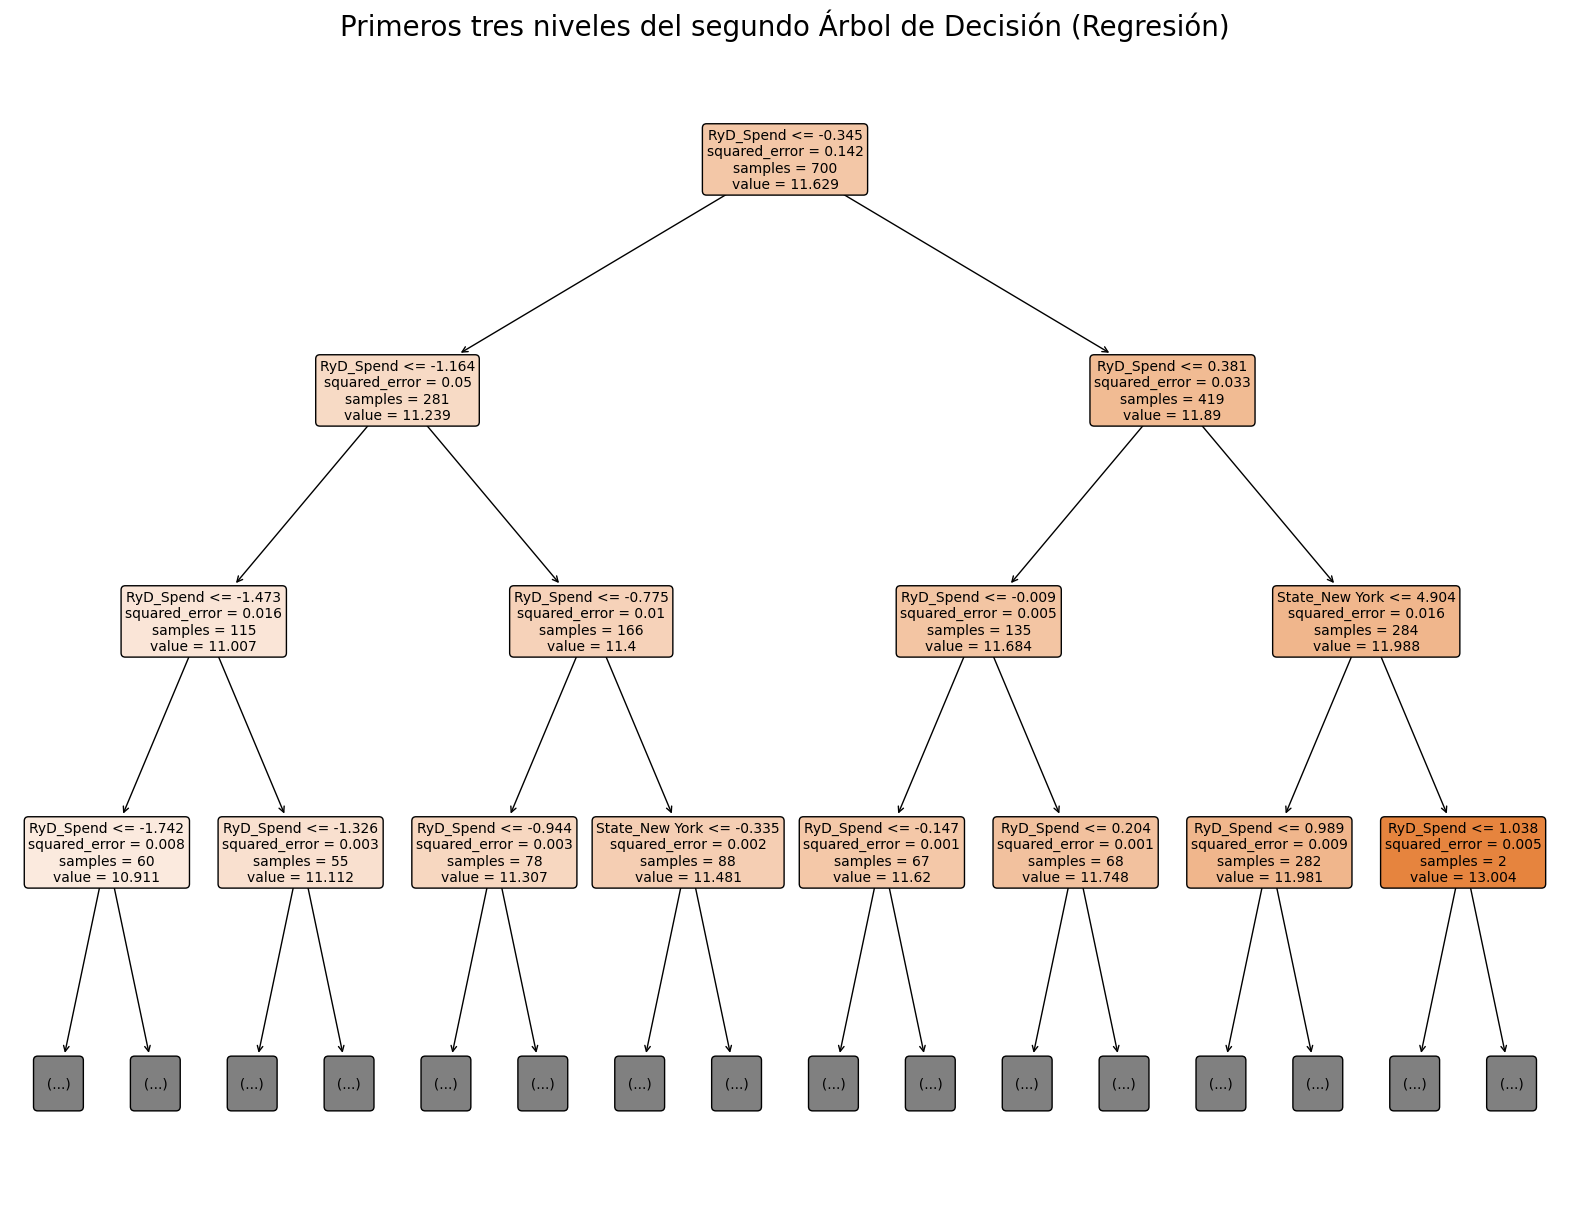

In [29]:
plt.figure(figsize=(20, 15))
plot_tree(mejor_arbol_2,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)

plt.title("Primeros tres niveles del segundo Árbol de Decisión (Regresión)", fontsize=20)
plt.show()

**Observaciones:**

Este gráfico también está dominado por la variable RyD_Spend, lo que confirma que esta es la característica más predictiva para estimar Profit, similar al primer árbol. En este caso, el criterio de división utilizado fue el squared_error (MSE), en lugar del absolute_error. La división inicial en la raíz RyD_Spend <= -0.345 separa el conjunto en dos ramas principales: la derecha, con un valor de Profit más alto, indicando que las empresas con mayor RyD Spend logran un mayor rendimiento. Las divisiones sucesivas continúan usando RyD_Spend como la característica principal. El squared_error en la raíz es 0.062, y el árbol busca reducir esta varianza cuadrática con cada división. A diferencia del primer árbol, la variable geográfica State_New York aparece ligeramente más arriba en la rama derecha, lo que sugiere que para esta partición de entrenamiento específica (70%), la ubicación comenzó a ofrecer una reducción de error significativa antes que en el otro modelo, aunque su importancia sigue siendo secundaria frente a RyD_Spend.

**Resultados de MAE, MSE y RMSE**

In [ ]:
from numpy import sqrt, expm1, log1p

# Predicciones
preds_test_20 = mejor_arbol_1.predict(X_test_20)
preds_test_30 = mejor_arbol_2.predict(X_test_30)

# Reversión de la transformación
preds_test_20_final = np.expm1(preds_test_20)
preds_test_30_final = np.expm1(preds_test_30)

# Función para imprimir las métricas
def calcular_metricas_finales(y_real_original, y_pred_final, nombre_set):
    mae = mean_absolute_error(y_real_original, y_pred_final)
    mse = mean_squared_error(y_real_original, y_pred_final)
    rmse = sqrt(mse)

    print(f"\nResultados para el Conjunto de {nombre_set} (ESCALA ORIGINAL):")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
    print(f"Raíz del ECM (RMSE): {rmse:.2f}")

print("Resultados de los Árboles de Decisión evaluados:")
calcular_metricas_finales(y_test_20_original, preds_test_20_final, "Prueba 20%")
calcular_metricas_finales(y_test_30_original, preds_test_30_final, "Prueba 30%")

Resultados de los Árboles de Decisión evaluados:

Resultados para el Conjunto de Prueba 20% (ESCALA ORIGINAL):
Error Absoluto Medio (MAE): 1334.34
Error Cuadrático Medio (MSE): 153187001.59
Raíz del ECM (RMSE): 12376.87

Resultados para el Conjunto de Prueba 30% (ESCALA ORIGINAL):
Error Absoluto Medio (MAE): 2513.01
Error Cuadrático Medio (MSE): 33010990.99
Raíz del ECM (RMSE): 5745.52


In [ ]:
print(f"Profundidad final del árbol 1: {mejor_arbol_1.get_depth()} y del árbol 2: {mejor_arbol_2.get_depth()}")

Profundidad final del árbol 1: 9 y del árbol 2: 5


**Observaciones:**

El problema principal es la inestabilidad del modelo de Árbol de Regresión individual, confirmado por esa diferencia notoria en la profundidad final (Árbol 1 a 9 y Árbol 2 a 5). El Árbol 1 (con profundidad 9) es un modelo sobreajustado, lo cual se traduce en un MAE decente 1334.34, pero que falla en los outliers del test, disparando el RMSE a 12376.87. Básicamente, es preciso en promedio, pero inútil cuando se equivoca.

Por otro lado, el Árbol 2 (con profundidad 5) es muy simple y se queda corto, lo que muestra sesgo alto. Su simplicidad le permite evitar los errores muy grandes (por eso tiene un RMSE bajo de 5745.52), pero a costa de la precisión diaria, elevando el MAE a 2513.01. En resumen, el Grid Search te dio dos modelos inestables: uno demasiado complejo (alta varianza) y otro demasiado simple (alto sesgo). Esto confirma que los datos tal vez no son ideales para un árbol de decisión sino para otro más complejo.


# 3) Drug type

## Carga de dataset 2

In [ ]:
#!gdown 1PUl4UHgaXtvmKfbrPm2XbWXcgRx0vfXj

Downloading...
From: https://drive.google.com/uc?id=1PUl4UHgaXtvmKfbrPm2XbWXcgRx0vfXj
To: /content/drugType.csv
100% 6.29k/6.29k [00:00<00:00, 16.8MB/s]


In [35]:
data_drugType = pd.read_csv('drugType.csv')
data_drugType.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


## Análisis exploratorio de datos

In [36]:
data_drugType.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


El dataset cuenta con 200 filas sin datos nulos y se distribuye en 6 variables:

Variables cuantitativas:
- Edad
- Rotación de Na a Potasio

Variables cualitativas:
- Sexo
- Blood Pressure Levels (BP) / Niveles de presión arterial
- Colesterol
- Droga

El dataset parece no contener valores faltantes en ninguna de sus variables o filas.

**Distribuciones de variables numéricas**

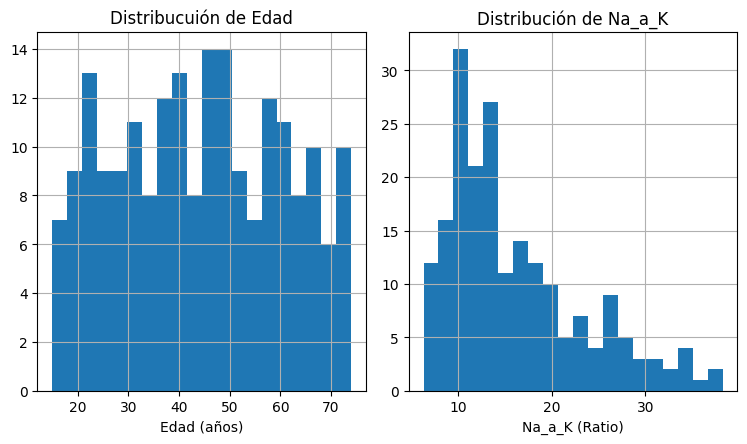

In [49]:
data_drugType.hist(figsize=(15, 20), bins=20, layout=(5,4))
plt.tight_layout()

# Agregar unidades
plt.subplot(5, 4, 1)
plt.xlabel("Edad (años)")
plt.title('Distribucuión de Edad')

plt.subplot(5, 4, 2)
plt.xlabel("Na_a_K (Ratio)")
plt.title('Distribución de Na_a_K')

plt.show()

La distribución de Edad parece ser multimodal y no simétrica, por lo que no tiene distribución normal. Mientras que la distribución de Na_a_K es unimodal y claramente asimétrica a la derecha. Se continúa con un formato boxplot para visualizar bien posibles outliers.

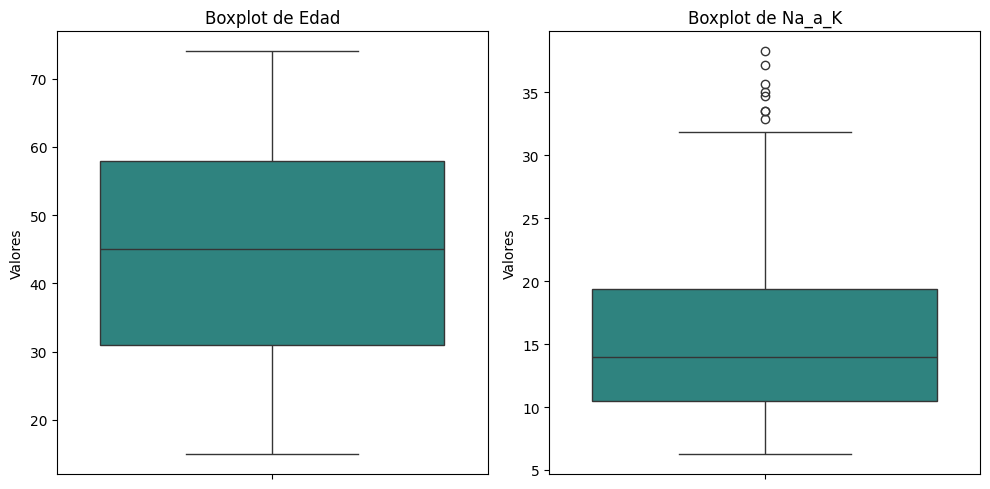

In [38]:
columnas = data_drugType.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.flatten()

for i, col in enumerate(columnas):
    sns.boxplot(y=data_drugType[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel('Valores')

plt.tight_layout()
plt.show()

Por un lado, se puede observar que Edad no presenta outliers. Por otro, en el caso de Na_a_K presenta algunos outliers alrededor de valores mayores a 30.

**Distribución de variables categóricas**

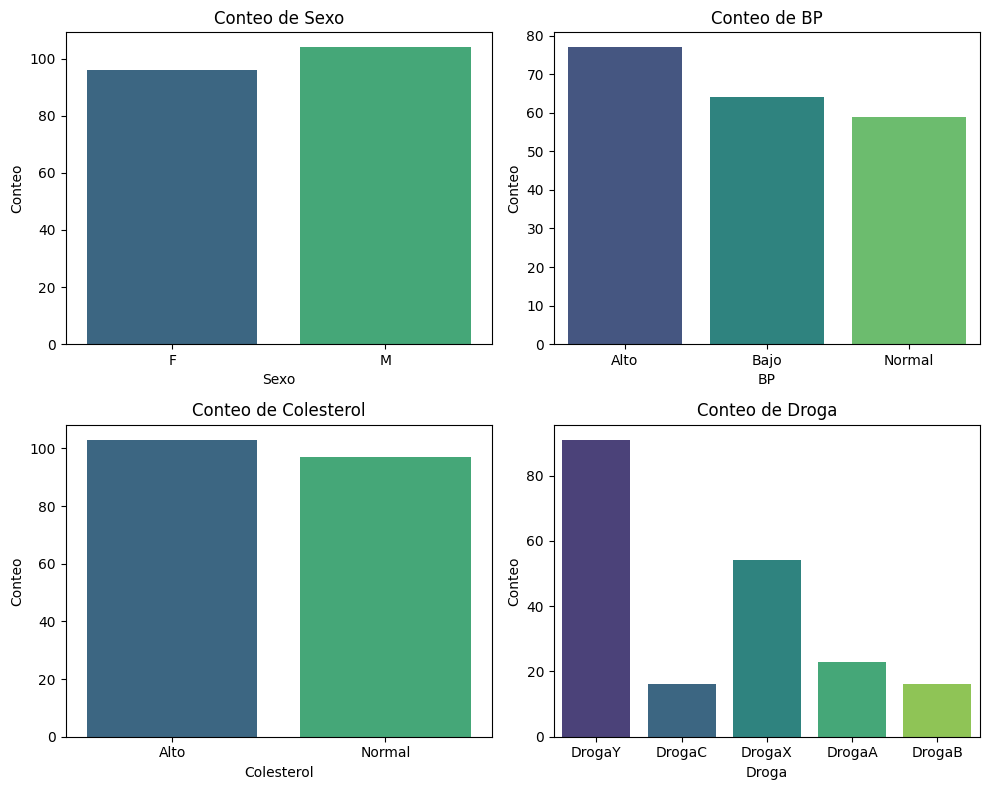

In [40]:
cols_categ = ['Sexo', 'BP', 'Colesterol', 'Droga']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, col in enumerate(cols_categ):
    ax_actual = axes.flatten()[i]

    sns.countplot(data=data_drugType, x=col, ax=ax_actual, palette='viridis')

    ax_actual.set_title(f'Conteo de {col}')
    ax_actual.set_xlabel(col)
    ax_actual.set_ylabel('Conteo')

plt.tight_layout()
plt.show()

Se observan categorías bien definidas, sin datos nulos. Cada uno de los valores que toma las cuatro variables cualitativas, se codifican con one-hot encoding, salvo Droga por ser una variable objetivo para modelos futuros. Esta será transformada con LabelEncoder. Se deberá tomar en cuenta en el modelado y evaluación el hecho de que esta variiable está desbalanceada.

In [41]:
ohe = OneHotEncoder(sparse_output=False)
categ_encod = ohe.fit_transform(data_drugType[['Sexo', 'BP', 'Colesterol']])

In [42]:
ohe_nombres = ohe.get_feature_names_out()
data_ohe = pd.DataFrame(categ_encod, columns=ohe_nombres, index=data_drugType.index)
data_ohe = data_ohe.astype(int)

In [43]:
data_completo = pd.concat([data_drugType, data_ohe], axis=1)
data_final2 = data_completo.drop(columns=['Sexo', 'BP', 'Colesterol'], axis=1)

In [44]:
y_droga = data_final2['Droga']
le = LabelEncoder()
droga_enc = le.fit_transform(y_droga)

**Observación** de resultado de LabelEncoding:

0 = 'DrogaA'; 1 = 'DrogaB'; 2 = 'DrogaC'; 3 = 'DrogaX'; 4 = 'DrogaY'

In [45]:
print(le.classes_)

['DrogaA' 'DrogaB' 'DrogaC' 'DrogaX' 'DrogaY']


In [46]:
np.unique(droga_enc)

array([0, 1, 2, 3, 4])

## División de datos y Escalado

In [47]:
X = data_final2.drop('Droga', axis=1)
y = droga_enc

Se construyen dos divisiones para modelos distintos.

In [48]:
# División 1 (80/20)
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42)

# División 2 (70/30)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42)

Tranformación logarítmica para Na_a_K y escalado con StandardScaler por la presencia de outliers antes vista.

In [50]:
for conj in [X_train_80, X_test_20, X_train_70, X_test_30]:
    conj['Na_a_K_log'] = np.log1p(conj['Na_a_K'])
    conj.drop('Na_a_K', axis=1, inplace=True)

In [51]:
scaler_1 = StandardScaler()
X_train_80_esc = scaler_1.fit_transform(X_train_80)
X_test_20_esc = scaler_1.transform(X_test_20)

In [52]:
scaler_2 = StandardScaler()
X_train_70_esc = scaler_2.fit_transform(X_train_70)
X_test_30_esc = scaler_2.transform(X_test_30)

In [53]:
print(f"Conjunto 1: Datos de entrenamiento: {X_train_80_esc.shape[0]} muestras. Datos de prueba: {X_test_20_esc.shape[0]} muestras.")
print(f"Conjunto 2: Datos de entrenamiento: {X_train_70_esc.shape[0]} muestras. Datos de prueba: {X_test_30_esc.shape[0]} muestras.")

Conjunto 1: Datos de entrenamiento: 160 muestras. Datos de prueba: 40 muestras.
Conjunto 2: Datos de entrenamiento: 140 muestras. Datos de prueba: 60 muestras.


# 4) Árbol de decisión sobre Droga

Se comienza con un árbol de decisión de clasificación base, con poda incluida.

In [72]:
#Parametros elegidos
criterio = 'gini'
max_prof = None
min_obs_sep = 20
min_obs_hoja = 5
alpha_poda = 0.05

clf_inicial = DecisionTreeClassifier(
    criterion=criterio,
    max_depth=max_prof,
    min_samples_split=min_obs_sep,
    min_samples_leaf=min_obs_hoja,
    ccp_alpha=alpha_poda,
    random_state=42)

In [73]:
clf_inicial.fit(X_train_80_esc, y_train_80)

DecisionTreeClassifier(ccp_alpha=0.05, min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [74]:
print(f"Profundidad final del árbol: {clf_inicial.get_depth()} (limitada por max_depth o la poda)")

Profundidad final del árbol: 4 (limitada por max_depth o la poda)


Ahora se desarrolla un árbol de decisión de clasificación, pero en esta ocasión se utiliza GridSearchCV para elegir de manera confiable sus hiperparámetros.

In [75]:
arb_decis_clas = DecisionTreeClassifier(random_state=42)

param_clas = {'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8, 10, None],
    'min_samples_split': [2, 10, 20, 40],
    'min_samples_leaf': [1, 5, 10, 20]}

In [76]:
GSCV_arb_clas = GridSearchCV(estimator=arb_decis_clas,
                           param_grid=param_clas,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

In [77]:
# Entrenamiento sobre la división de datos más grande
GSCV_arb_clas.fit(X_train_80_esc, y_train_80)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8, 10, None],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 10, 20, 40]},
             scoring='accuracy', verbose=1)

In [78]:
mejor_arbol_clas = GSCV_arb_clas.best_estimator_

Parámetros elegidos por GridSearchCV:

In [79]:
print(GSCV_arb_clas.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


Se grafica el árbol "podado" con la elección hecha con GridSearchCV.

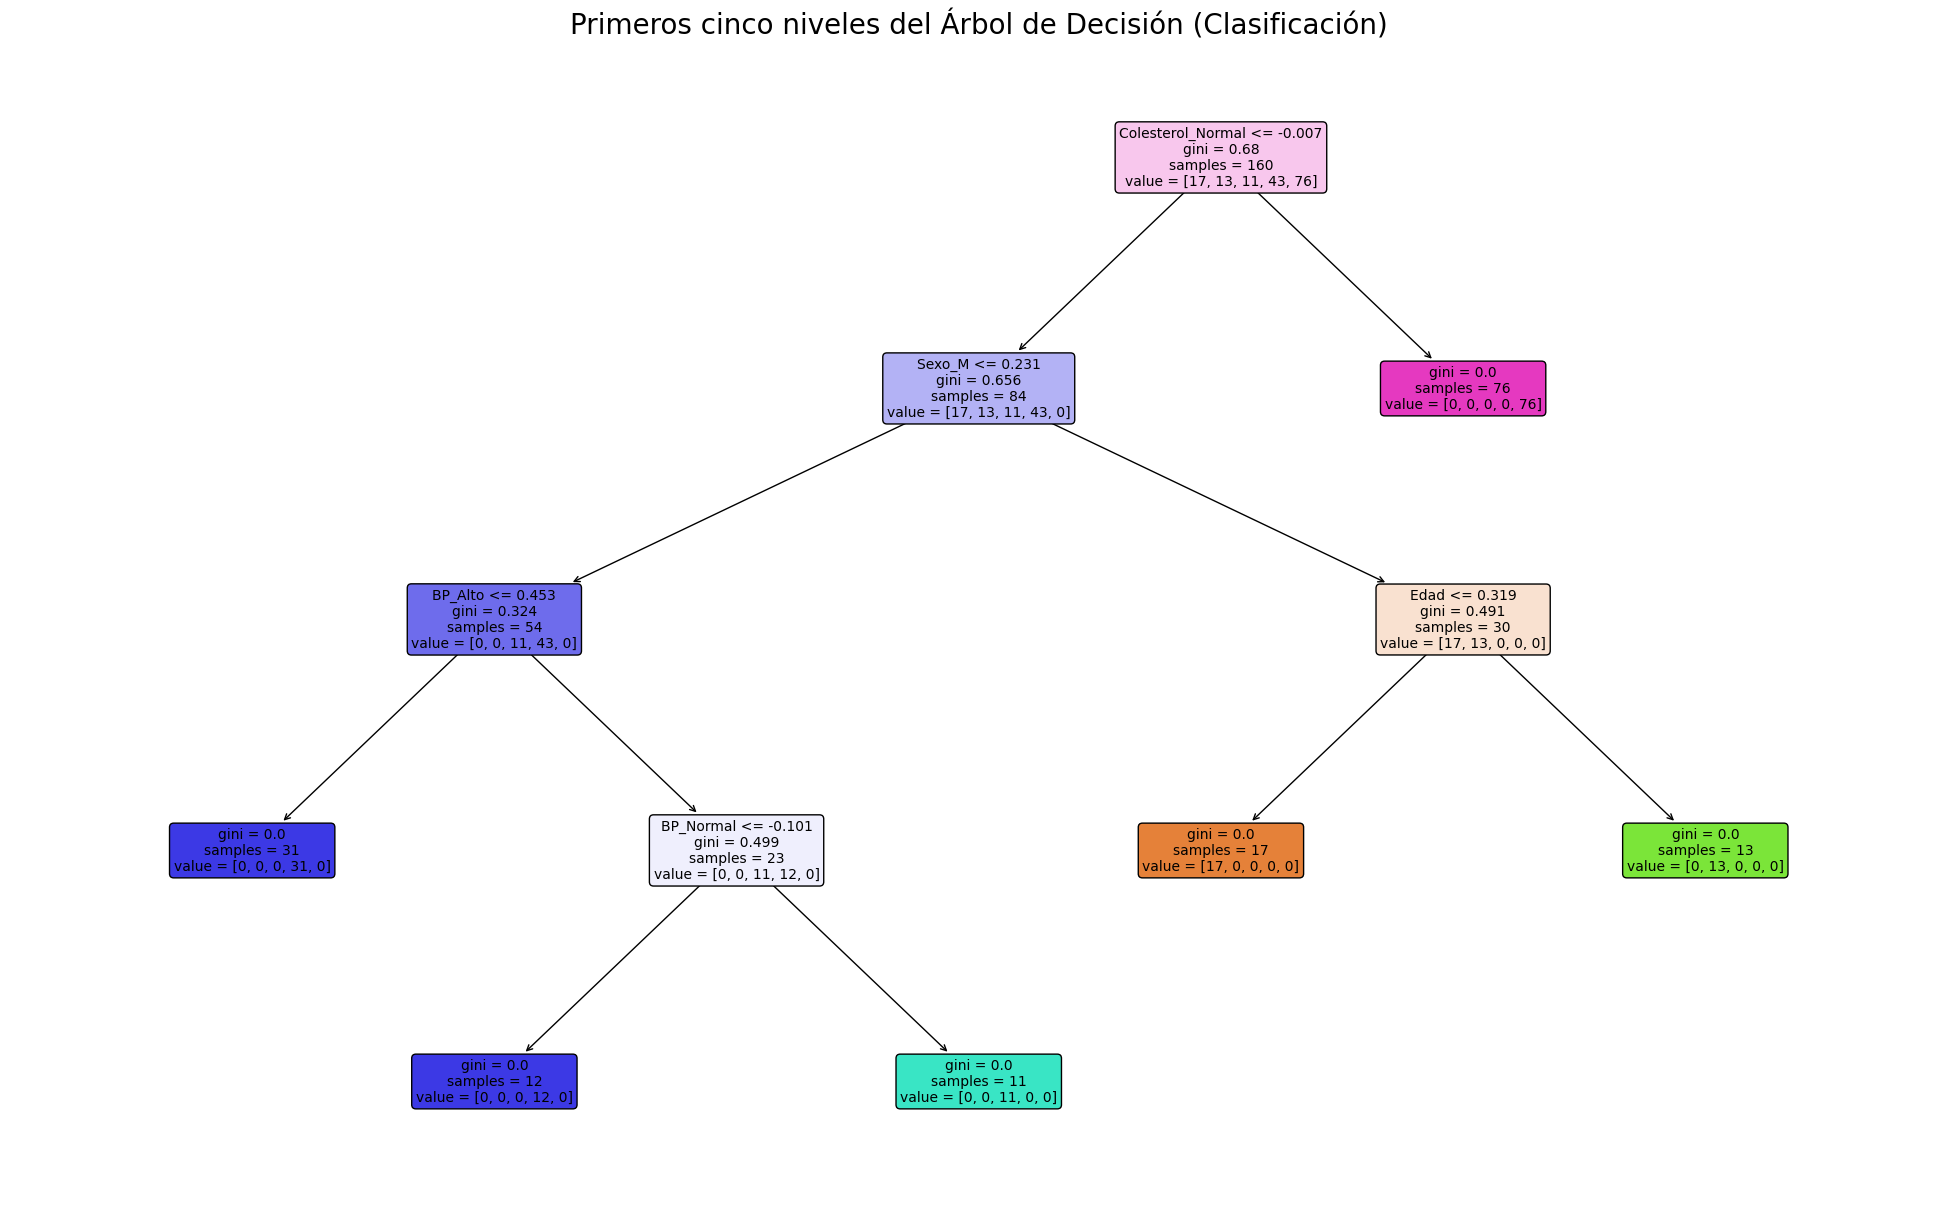

In [80]:
plt.figure(figsize=(25, 15))
plot_tree(mejor_arbol_clas,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=10)

plt.title("Primeros cinco niveles del Árbol de Decisión (Clasificación)", fontsize=20)
plt.show()

(Completar)

Resultados sobre los conjuntos de test con Matriz de Confusión y Precisión, Exhaustividad y Exactitud.

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [101]:
y_pred_20 = mejor_arbol_clas.predict(X_test_20_esc)
cm = confusion_matrix(y_test_20, y_pred_20)

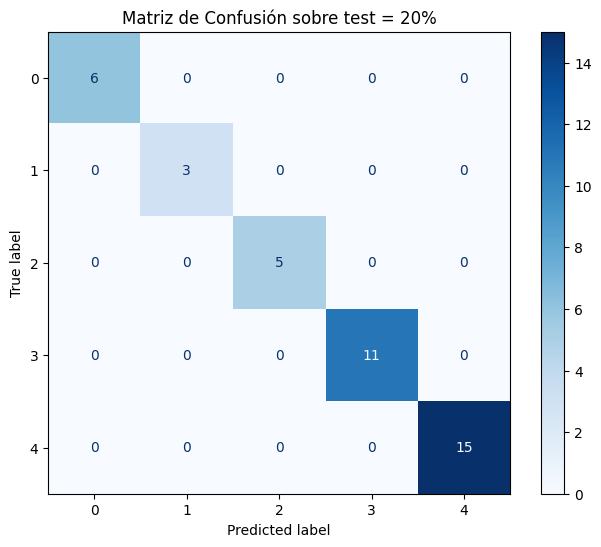

In [102]:
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=mejor_arbol_clas.classes_)

disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión sobre test = 20%')
plt.show()

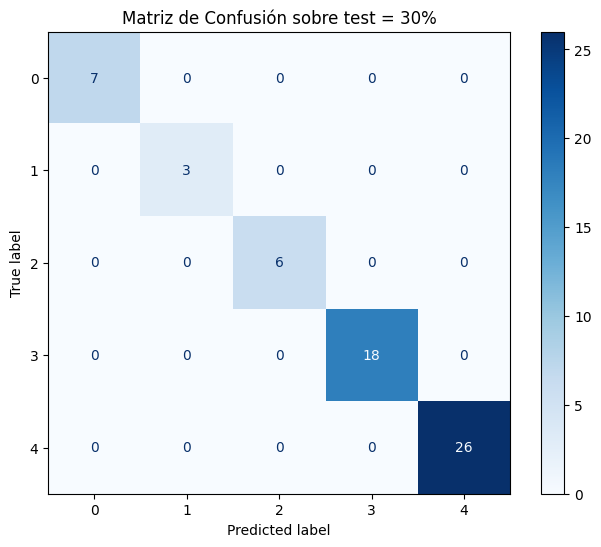

In [103]:
y_pred_30 = mejor_arbol_clas.predict(X_test_30_esc)
cm2 = confusion_matrix(y_test_30, y_pred_30)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, 
                              display_labels=mejor_arbol_clas.classes_)

disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión sobre test = 30%')
plt.show()

Precisión, Exhaustividad y Exactitud:

In [95]:
# Predicciones 1
y_predics_20 = mejor_arbol_clas.predict(X_test_20_esc)

# Métricas finales
precision1 = precision_score(y_test_20, y_predics_20, average='weighted')
exhaustividad1 = recall_score(y_test_20, y_predics_20, average='weighted')
exactitud1 = accuracy_score(y_test_20, y_predics_20)

In [96]:
# Predicciones 2
y_predics_30 = mejor_arbol_clas.predict(X_test_30_esc)

# Métricas finales
precision2 = precision_score(y_test_30, y_predics_30, average='weighted')
exhaustividad2 = recall_score(y_test_30, y_predics_30, average='weighted')
exactitud2 = accuracy_score(y_test_30, y_predics_30)

In [99]:
df_preds = {'Resultados Test 80/20': [precision1, exhaustividad1, exactitud1],
    'Resultados Test 70/30': [precision2, exhaustividad2, exactitud2]}

metricas = ['Precisión (weighted)', 'Exhaustividad (weighted)', 'Exactitud']
df_res = pd.DataFrame(df_preds, index=metricas)
df_res

,Resultados Test 80/20,Resultados Test 70/30
Precisión (weighted),1.0,1.0
Exhaustividad (weighted),1.0,1.0
Exactitud,1.0,1.0


Se chequea lo visto con Validación Cruzada:

In [104]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(
    estimator=mejor_arbol_clas,
    X=X_train_80_esc,
    y=y_train_80,
    scoring='precision_weighted',
    cv=5 
)

# 2. Interpretar los resultados
print(f"Puntuaciones de Validación Cruzada (5 pliegues): {scores}")
print(f"Puntuación media (CV Mean precision_weighted): {np.mean(scores):.4f}")
print(f"Desviación Estándar (CV Std Dev): {np.std(scores):.4f}")

Puntuaciones de Validación Cruzada (5 pliegues): [1.        1.        1.        0.9765625 1.       ]
Puntuación media (CV Mean precision_weighted): 0.9953
Desviación Estándar (CV Std Dev): 0.0094


In [ ]:
scores2 = cross_val_score(
    estimator=mejor_arbol_clas,
    X=X_train_70_esc,
    y=y_train_70,
    scoring='precision_weighted',
    cv=5 
)

# 2. Interpretar los resultados
print(f"Puntuaciones de Validación Cruzada (5 pliegues): {scores2}")
print(f"Puntuación media (CV Mean precision_weighted): {np.mean(scores2):.4f}")
print(f"Desviación Estándar (CV Std Dev): {np.std(scores2):.4f}")

Puntuaciones de Validación Cruzada (5 pliegues): [1.         1.         1.         0.97321429 1.        ]
Puntuación media (CV Mean precision_weighted): 0.9946
Desviación Estándar (CV Std Dev): 0.0107


# 5) Estimación de la variable Droga con Bayes Ingenuo

Se busca estimar la variable Droga a través de Bayes Ingenuo. El dataset utilizado hasta ahora posee variables categóricas transformadas con OneHotEncoding y LabelEncoder. Los atributos cuantitativos que se deben discretizar son Edad y Na_a_K.

In [181]:
X.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
0,23,25.355,1,0,1,0,0,1,0
1,47,13.093,0,1,0,1,0,1,0
2,47,10.114,0,1,0,1,0,1,0
3,28,7.798,1,0,0,0,1,1,0
4,61,18.043,1,0,0,1,0,1,0


In [182]:
cols_nums_discret = ['Edad', 'Na_a_K']

In [183]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [184]:
discretizador = KBinsDiscretizer(n_bins=5, # cortar cada variable en 5 cajas
                                strategy='quantile', # misma cantidad de muestras
                                encode='onehot-dense') # 5 cajas en 5 columnas (0 y 1)

In [185]:
preprocesador = ColumnTransformer(
    transformers=[('discretizar', discretizador, cols_nums_discret)],
    remainder='passthrough')

In [186]:
pipeline_bayes = Pipeline(steps=[
    ('preprocesar', preprocesador),
    ('modelo', MultinomialNB())])

In [187]:
pipeline_bayes.fit(X_train_80, y_train_80)

y_pred_nb_20 = pipeline_bayes.predict(X_test_20)
y_pred_nb_30 = pipeline_bayes.predict(X_test_30)

In [188]:
# Métricas 1
precision_nb1 = precision_score(y_test_20, y_pred_nb_20, average='weighted', zero_division=0)
exhaustividad_nb1 = recall_score(y_test_20, y_pred_nb_20, average='weighted')
exactitud_nb1 = accuracy_score(y_test_20, y_pred_nb_20)

# Métricas 2
precision_nb2 = precision_score(y_test_30, y_pred_nb_30, average='weighted', zero_division=0)
exhaustividad_nb2 = recall_score(y_test_30, y_pred_nb_30, average='weighted')
exactitud_nb2 = accuracy_score(y_test_30, y_pred_nb_30)

In [189]:
data_nb = {
    'Resultados Test 80/20': [precision_nb1, exhaustividad_nb1, exactitud_nb1],
    'Resultados Test 70/30': [precision_nb2, exhaustividad_nb2, exactitud_nb2]}
metricas_nb = ['Precisión (weighted)', 'Exhaustividad (weighted)', 'Exactitud']

resultados_nb = pd.DataFrame(data_nb, index=metricas_nb)
resultados_nb

,Resultados Test 80/20,Resultados Test 70/30
Precisión (weighted),0.862124,0.873184
Exhaustividad (weighted),0.825000,0.850000
Exactitud,0.825000,0.850000


La estimación de la variable Droga con Bayes Ingenuo obtuvo una precisión del 86.21 % y exhaustividad y exactitud del 82.5 % en la partición 80/20. En la otra partición 70/30 obtuvo precisión del 87.31 % y exhaustividad y exactitud del 85 %.

Las diferencias entre 80/20 y 70/30 son pequeñas, lo que sugiere que el rendimiento es estable y la generalización es buena.

No hay evidencia clara de sobreajuste ni subajuste: el modelo funciona parecido con distintos tamaños de entrenamiento.

# 6) Estimación de la variable Droga con k-NN

Se busca estimar la variable Droga mediante k-NN. Se utilizará GridSearch para buscar los mejores hiperparámetros de este método.

In [190]:
knn_clf = KNeighborsClassifier()

In [191]:
param_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3] # p solo se usa con 'minkowski'
    }

In [192]:
GSCV_knn = GridSearchCV(estimator=knn_clf,
                        param_grid=param_knn,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1)

In [193]:
# Entrenamiento
GSCV_knn.fit(X_train_80_esc, y_train_80)

print("Mejores parámetros encontrados:")
print(GSCV_knn.best_params_)

mejor_knn = GSCV_knn.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores parámetros encontrados:
{'metric': 'minkowski', 'n_neighbors': 11, 'p': 3}


In [194]:
# Predicciones
y_pred_knn_20 = mejor_knn.predict(X_test_20_esc)
y_pred_knn_30 = mejor_knn.predict(X_test_30_esc)

# Métricas
precision_knn1 = precision_score(y_test_20, y_pred_knn_20, average='weighted', zero_division=0)
exhaustividad_knn1 = recall_score(y_test_20, y_pred_knn_20, average='weighted')
exactitud_knn1 = accuracy_score(y_test_20, y_pred_knn_20)
precision_knn2 = precision_score(y_test_30, y_pred_knn_30, average='weighted', zero_division=0)
exhaustividad_knn2 = recall_score(y_test_30, y_pred_knn_30, average='weighted')
exactitud_knn2 = accuracy_score(y_test_30, y_pred_knn_30)

# Visualización de resultados
df_preds_knn = {
    'Resultados Test 80/20': [precision_knn1, exhaustividad_knn1, exactitud_knn1],
    'Resultados Test 70/30': [precision_knn2, exhaustividad_knn2, exactitud_knn2]}

metricas_knn = ['Precisión (weighted)', 'Exhaustividad (weighted)', 'Exactitud']

resultados_knn = pd.DataFrame(df_preds_knn, index=metricas_knn)
resultados_knn

,Resultados Test 80/20,Resultados Test 70/30
Precisión (weighted),0.878846,0.867758
Exhaustividad (weighted),0.875000,0.850000
Exactitud,0.875000,0.850000


En términos generales se puede observar a partir de estos resultados que el modelo k-NN muestra un buen rendimiento, logrando una exactitud del 87,50% en el conjunto de prueba 80/20 y del 85% para en el de 70/30.

# 7) Conclusión

**Sobre modelado sobre 1000_Companies.csv**

En el punto 1 y 2 del trabajo se tuvo que realizar un Análisis de Regresión. La matriz de correlación mostró que las variables R&D_Spend y MarketingSpend presentan una correlación muy alta (0.98), evidenciando multicolinealidad. Esto significa que ambas variables aportan información muy similar. La estimación de Profit con Árboles de decisión de Regresión identificó a R&D_Spend como el principal factor predictivo y los beneficios aumentan notablemente a medida que crece la inversión en R&D_Spend y Marketing.
Las métricas tuvieron una notable diferencia lo cual indica sobreajuste. El modelo es inútil para la predicción, aunque confirmó que RyD_Spend es el motor del Profit y éste también logró capturar la relación principal entre inversión y rentabilidad, la cuál indicaría que "una mayor inversión estratégica genera mayores retornos".

**Sobre modelado sobre drugType.csv**

En los otros puntos se realizó un Análisis de Clasificación de Tipo de droga. El conjunto de datos se dividió en proporciones 80/20 y 70/30. Los tres métodos Árbol, Bayes y k-NN obtuvieron resultados satisfactorios, destacando el árbol de decisión como el más preciso (aunque su "perfección" resulta extraño) y explicativo, luego KNN (87 %) y Bayes (85 %).
Para profundizar más en este último detalle, al comparar Bayes Ingenuo y kNN, ambos demuestran ser robustos y fiables. Sin embargo, el modelo KNN se perfila como la mejor opción. Si bien en la partición 70/30 sus resultados son prácticamente idénticos a los de Naive Bayes (ambos con 0.850 de exactitud), en la partición 80/20 el KNN muestra una superioridad clara, alcanzando una Exactitud de 0.875 frente al 0.825 de Naive Bayes. Por lo tato, si KNN iguala el rendimiento de Naive Bayes en un escenario y lo supera en el otro, puede considerarse el modelo (aunque sea por poco) más efectivo para este problema.

